## Underway Temperature and Salinity Plotting

In this tutorial, we will show how to make simple along-track plots using data collected by the ship-mounted, underway temperature and salinity sensors during a VirtualShip expedition. This records temperature/salinity at regular intervals as the ship moves through the ocean.

There are example plots embedded in this notebook, but these will ultimately be replaced by your own versions if you are working through the notebook with your own expedition output.

### Set up

#### Imports

The first step is to import the Python packages required for post-processing the data and plotting. 

<div class="alert alert-block alert-success"> 
<b>Tip:</b> You may need to set the Kernel to the relevant (Conda) environment in the top right of this notebook to access the required packages! 
</div>

In [1]:
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

#### Data directory

Next, you should set `data_dir` to be the path to your expedition results in the code block below. You should replace `"/path/to/EXPEDITION/results/"` with the path for your machine.

<div class="alert alert-block alert-success"> 
<b>**TIP**:</b> You can get the path to your expedition results by navigating to the `results` folder in Terminal (using `cd`) and then using the `pwd` command. This will print your working directory which you can copy to the `data_dir` variable in this notebook. Don't forget to keep it as a string (in "quotation" marks)!
</div>

In [ ]:
# set data dir path

data_dir = "/path/to/EXPEDITION/results/"  # set this to be where your expedition output data is located on your (virtual) machine

#### Load data

We are now ready to read in the data using the `xarray` package.

In [3]:
# load underway temperature and salinity data

underway_st_ds = xr.open_dataset(f"{data_dir}/underwater_st.zarr")

### Plotting

<div class="alert alert-block alert-info"> 
<b>**NOTE**:</b> The plots produced next are a starting point for your analysis. You are encouraged to make further adjustments and enhancements to suit your own data and research question.
</div>

We will now produce plot(s) of the underway temperature/salinity tracks at the sea surface. The expedition route is shown by the line on the map, with the colour map indicating the temperature/salinity value at each point along the track.

Choose below which variable you would like to plot by setting the `PLOT_VARIABLE` variable to either `"temperature"` or `"salinity"`.


In [4]:
PLOT_VARIABLE = "salinity"  # options: 'temperature', 'salinity'

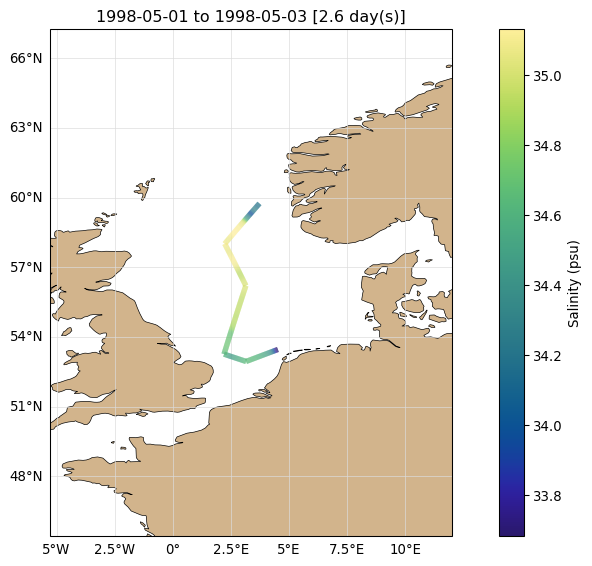

In [6]:
VARIABLES = {
    "temperature": {
        "cmap": "cmo.thermal",
        "label": "Temperature (°C)",
        "ds_name": "T",
    },
    "salinity": {
        "cmap": "cmo.haline",
        "label": "Salinity (psu)",
        "ds_name": "S",
    },
}

# fig
fig = plt.figure(figsize=(10, 6), dpi=96)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# extract trajectory data
lons = underway_st_ds["lon"][:].sel(trajectory=0).squeeze().values
lats = underway_st_ds["lat"][:].sel(trajectory=0).squeeze().values
var = (
    underway_st_ds[VARIABLES[PLOT_VARIABLE]["ds_name"]][:]
    .sel(trajectory=0)
    .squeeze()
    .values
)

# segments for LineCollection
points = np.array([lons, lats]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# coloured by temperature
LINEWIDTH = 4.0
lc = LineCollection(
    segments,
    cmap=VARIABLES[PLOT_VARIABLE]["cmap"],
    norm=mcolors.Normalize(vmin=np.nanmin(var), vmax=np.nanmax(var)),
    array=var[:-1],
    linewidth=LINEWIDTH,
    zorder=3,
    transform=ccrs.PlateCarree(),
)
ax.add_collection(lc)

# additional map features
latlon_buffer = 7.5  # degrees (adjust this to 'zoom' in/out in the plot)
ax.set_extent(
    [
        underway_st_ds.lon.min() - latlon_buffer,
        underway_st_ds.lon.max() + latlon_buffer,
        underway_st_ds.lat.min() - latlon_buffer,
        underway_st_ds.lat.max() + latlon_buffer,
    ],
    crs=ccrs.PlateCarree(),
)
ax.coastlines(linewidth=0.5, color="black")
ax.add_feature(cfeature.LAND, facecolor="tan")
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color="gainsboro",
    alpha=1.0,
    linestyle="-",
    zorder=0,
)
gl.top_labels = False
gl.right_labels = False

# add colorbar
sm = plt.cm.ScalarMappable(
    cmap=VARIABLES[PLOT_VARIABLE]["cmap"],
    norm=mcolors.Normalize(
        vmin=float(underway_st_ds[VARIABLES[PLOT_VARIABLE]["ds_name"]].min()),
        vmax=float(underway_st_ds[VARIABLES[PLOT_VARIABLE]["ds_name"]].max()),
    ),
)
sm._A = []
cbar = plt.colorbar(
    sm, ax=ax, orientation="vertical", label=VARIABLES[PLOT_VARIABLE]["label"]
)

dates = (
    underway_st_ds["time"][:].sel(trajectory=0).squeeze().min(skipna=True).values,
    underway_st_ds["time"][:].sel(trajectory=0).squeeze().max(skipna=True).values,
)
n_days = (np.datetime64(dates[1]) - np.datetime64(dates[0])) / np.timedelta64(1, "D")
plt.title(
    f"{dates[0].astype('datetime64[D]')} to {dates[1].astype('datetime64[D]')} [{n_days:.1f} day(s)]",
    fontsize=12,
)

plt.tight_layout()